In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

We start by loading in and cleaning the data. The process of cleaning the data involves taking the beam and subtracting off the an average of the ambient noise in the room. From this, we then subtract of the dark to remove the hot pixels.
$$
    I_{\textrm{cleaned}}(x,y) = 
    \left[
        I_{\textrm{Beam}}(x,y) - I_{\textrm{Ambient}}(x,y)
    \right] - I_{\textrm{Dark}}(x,y)
$$
When this is done, we end up with the outer region intensity values being negative. This is due to the fact that in the beam dataset, the edges of the CCD get less fluence. This is due to the large flux value of the beam in the center causing radial darkening out at the edges similar to a camera pointing at a bright source (Find a source and better explination). To fix this, we renormalize the data such that the minimum intensity is our new zero point. All other intensity values are measured relative to this.

In [3]:
# Loads in all the data from the master data folder
data_path  = '../01-Data\master_data'
data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
data       = [np.loadtxt(os.path.join(data_path, file), delimiter=',') for file in data_files]

dark    = data[0]
beam    = data[1]
ambient = data[2]

In [4]:
# Gets the cleaned beam data and the coordinate variables
# cleaned_beam = (beam - ambient) - dark # Subtracted
cleaned_beam = beam  # Un-subtracted

dim_y, dim_x = cleaned_beam.shape
x_pix = np.linspace(0,10, dim_x)
y_pix = np.linspace(0,10, dim_y)

dx = 6.45 # micrometers
dy = dx
x_coords = x_pix * dx
y_coords = y_pix * dy

Now we can plot the beam

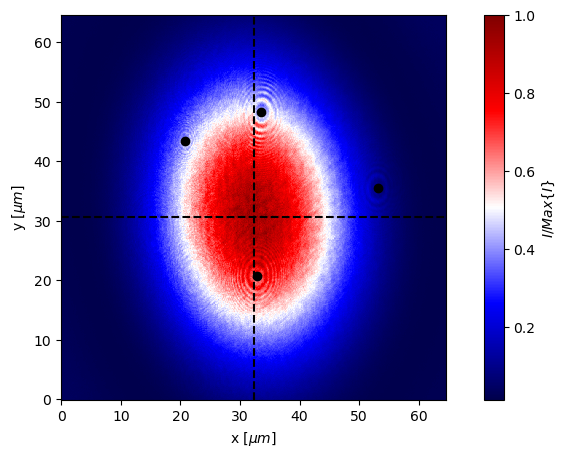

In [5]:
cmap =  'seismic'
fig,ax1 = plt.subplots(1, figsize=(10,5))

## Plot 1 ##
ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), label='cleaned beam', cmap = cmap)
ax1.set_xlabel('x $[\mu m]$')
ax1.set_ylabel('y [$\mu m$]')

# Sets a colourbar
cbar = plt.colorbar(ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), cmap = cmap))
# cbar = plt.colorbar(ax.pcolormesh(master_dark, cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')
ax1.set_aspect('equal')

# Sets the middle of the plot
ix = 265
iy = 180
x_center = x_coords[ix]
y_center = y_coords[iy]
ax1.axvline(x_center, color='k', linestyle='--')
ax1.axhline(y_center, color='k', linestyle='--')

# Plots points at the center of each dust
# particle diffraction pattern
# particle 1
i1x = x_coords[274]
i1y = y_coords[283]
ax1.plot(i1x, i1y, 'ko')

# # particle 2
i2x = x_coords[268]
i2y = y_coords[122]
ax1.plot(i2x,i2y, 'ko')

# # particle 3
i3x = x_coords[170]
i3y = y_coords[255]
ax1.plot(i3x,i3y, 'ko')

# # particle 4
i3x = x_coords[434]
i3y = y_coords[208]
ax1.plot(i3x,i3y, 'ko')

We can see that we don't have a perfectly circular beam. This is because the light incident on the CCD is not directly on the pinhole-detector axis but makes an angle $\phi$ to it. This causes us to see a conic section of the laser hence the elliptical shape. To find the semi-major and minor axes of this ellipse, we look at the full width half max (FWHM) of the x and y profiles.

In [6]:
# Defies a gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Defines a sinc function
def sinc(x, a, b):
    return(a * np.sin(b*x)/x)

In [7]:
# Gets the x and y profiles of the beam
x_profile = cleaned_beam[iy, :]
y_profile = cleaned_beam[:, ix]

# Fits a gaussian to the x and y profiles
x_model = curve_fit(gaussian, x_coords, x_profile)
y_model = curve_fit(gaussian, y_coords, y_profile)
 
# gets the errors on the models
x_err = np.sqrt(np.diag(x_model[1]))
y_err = np.sqrt(np.diag(y_model[1]))

# Calculates the fits
x_fit = gaussian(x_coords, *x_model[0])
y_fit = gaussian(y_coords, *y_model[0])

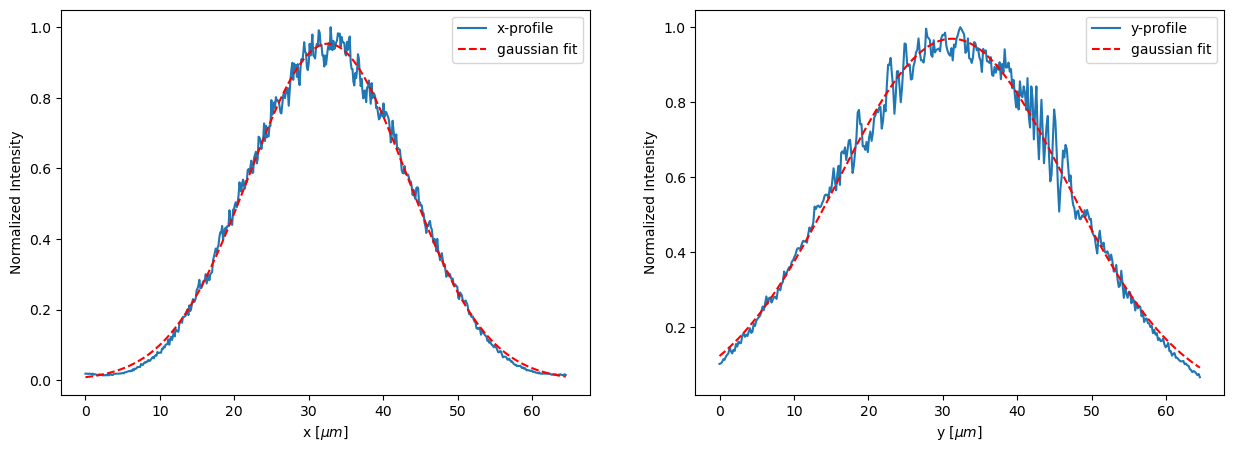

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# X-profile
ax1.plot(x_coords, x_profile / np.max(x_profile), label='x-profile')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('Normalized Intensity')
ax1.plot(x_coords, x_fit / np.max(x_profile), 'r--', label='gaussian fit')
ax1.legend()
# ax1.set_aspect('equal')

# Y-profile
ax2.plot(y_coords, y_profile / np.max(y_profile), label='y-profile')
ax2.set_xlabel('y [$\mu m$]')
ax2.set_ylabel('Normalized Intensity')
ax2.plot(y_coords, y_fit / np.max(y_profile), 'r--', label='gaussian fit')
ax2.legend()
# ax2.set_aspect('equal')

plt.show()

$$
    \textrm{FWHM} = 2\sigma\sqrt{2ln2}
$$

In [9]:
# finds the FWHM of the gaussian fits
x_fwhm = 2 * np.sqrt(2 * np.log(2)) * x_model[0][2]
y_fwhm = 2 * np.sqrt(2 * np.log(2)) * y_model[0][2]

# gets the FWHM error
x_fwhm_err = np.abs(2 * np.sqrt(2 * np.log(2)) * (x_err[2]*x_model[0][2]))
y_fwhm_err = np.abs(2 * np.sqrt(2 * np.log(2)) * (y_err[2]*y_model[0][2]))

print(f'x FWHM: {x_fwhm:0.2f} +/- {x_fwhm_err:0.2f} micrometers')
print(f'y FWHM: {y_fwhm:0.2f} +/- {y_fwhm_err:0.2f} micrometers')

x FWHM: -25.05 +/- 0.62 micrometers
y FWHM: -36.21 +/- 2.27 micrometers


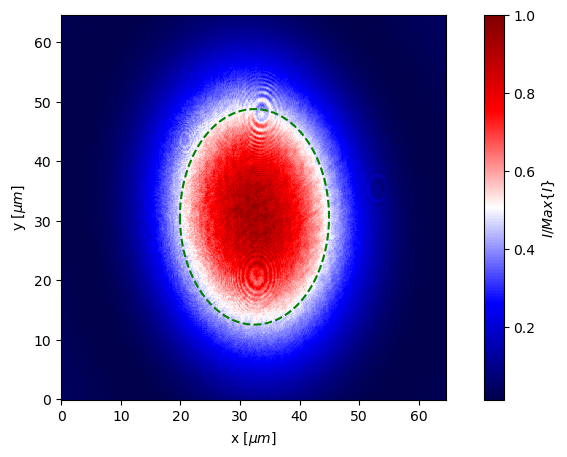

In [10]:
cmap =  'seismic'
fig,ax1 = plt.subplots(1, figsize=(10,5))

## Plot 1 ##
ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), label='cleaned beam', cmap = cmap)
ax1.set_xlabel('x $[\mu m]$')
ax1.set_ylabel('y [$\mu m$]')

# Sets a colourbar
cbar = plt.colorbar(ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), cmap = cmap))
# cbar = plt.colorbar(ax.pcolormesh(master_dark, cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')
ax1.set_aspect('equal')

# Sets the middle of the plot
ix = 265
iy = 180
x_center = x_coords[ix]
y_center = y_coords[iy]
# ax.axvline(x_center, color='k', linestyle='--')
# ax.axhline(y_center, color='k', linestyle='--')

# Plots a circle around the chosen center
# R = 15
# theta = np.linspace(0,2*np.pi,1000)
# x_circ = x_center + R*np.cos(theta)
# y_circ = y_center + R*np.sin(theta)
# ax1.plot(x_circ, y_circ, 'k--')

# Plots an ellipse around the chosen center
a = y_fwhm / 2  # Semi-Major axis
b = x_fwhm / 2  # Semi-Minor axis
theta = np.linspace(0,2*np.pi,1000)
x_circ = x_center + b*np.cos(theta)
y_circ = y_center + a*np.sin(theta)
ax1.plot(x_circ, y_circ, 'g--')

Where half of the FWHM of each profile gives the semi-major and semi-minor axes. Now assuming that the laser makes only one angle of incidence with the CCD in the vertical direction, we can work out what the angle of incidence should be. To get the formula for the angle; consider two surfaces, a cone and a plane
$$
    z^2 = x^2+y^2 \quad\quad\quad\quad z = ax
$$
We want the angle made from the axis through the cone. This is given by
$$
    \phi = \frac{\pi}{2} - \arctan(a)
$$
It can be shown that $a\in(0,1)$ defines an ellipse. Thus we can think of $a$ as the eccentricity (This can also be verified by shifting the plane up by some constant $c$ and plugging $z$ into the equation of the cone to generate a conic section. Doing this will give $a=e$ by comparing to the known formula). Thus,
$$
    \phi = \frac{\pi}{2} - \arctan(e) = \frac{\pi}{2} - \arctan\left(\sqrt{1-\left(\frac{b}{a}\right)^2}\right)
$$

The uncertianty in the angle comes from both $a$ and $b$ leading to the equation
$$
    \delta\phi = \sqrt{
        \left(\frac{\partial\phi}{\partial a}\delta a\right)^2 + 
        \left(\frac{\partial\phi}{\partial b}\delta b\right)^2
        }
$$
Analytically, we can compute this and get the form of the error. Instead of doing this by hand, sympy is used

In [11]:
import sympy as sp
a_s,b_s   = sp.symbols('a b')
delta_a_s = sp.Symbol('\delta a'); delta_b_s = sp.Symbol('\delta b')
phi_s     = sp.symbols('phi')
func      = sp.pi/2 - sp.atan(sp.sqrt(1-(b_s/a_s)**2))

term1 = sp.diff(func,a_s)*delta_a_s
term2 = sp.diff(func,b_s)*delta_b_s
error = sp.sqrt(term1**2 + term2**2)
error.simplify()

sqrt(b**2*(\delta a**2*b**2 + \delta b**2*a**2)/((a**2 - b**2)*(2*a**2 - b**2)**2))

In [12]:
# Calculates the angle of incidence of the beam
e       = np.sqrt(1-(b/a)**2)
phi     = np.pi/2 - np.arctan(e)
phi_deg = phi*180/np.pi          # convert angle to degrees
a_err   = x_fwhm_err / 2
b_err   = y_fwhm_err / 2

# calculates the error on the angle of incidence
err_phi = np.sqrt((b**2 * (a_err**2*b**2 + b_err**2*a**2)) / ((a**2 - b**2) * (2*a**2 - b**2)**2))

print(f'angle of incidence: {phi_deg:0.2f} +/- {err_phi:0.2f} degrees')

angle of incidence: 54.16 +/- 0.04 degrees


## Looks at fitting the first dust speck with a funnction (to be determined which)
We start by focusing in on one of the dust specs to get an idea of the profiles

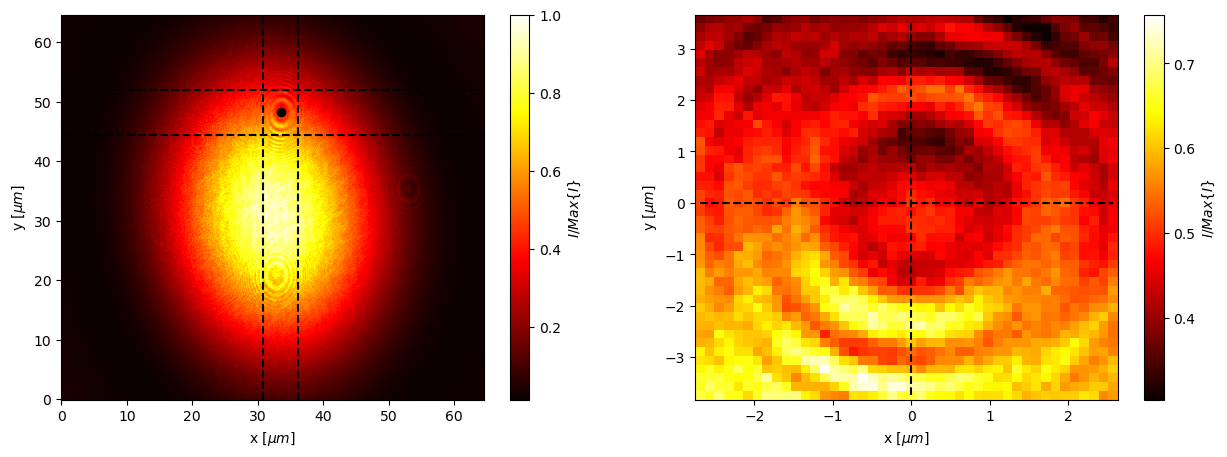

In [38]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

## PLot 1: Total Picture
ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), label='cleaned beam', cmap = 'hot')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('y [$\mu m$]')

# Sets a colourbar
cbar = plt.colorbar(ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), cmap = 'hot'))
# cbar = plt.colorbar(ax.pcolormesh(master_dark, cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')
# ax1.set_aspect('equal')

# Plots a box around the point of interest
i1x = 274
i1y = 283
ax1.plot(x_coords[i1x], y_coords[i1y], 'ko')
d = 22
x_start = i1x - d; x_end = i1x + d
y_start = i1y - d ; y_end   = i1y + d
ax1.axvline(x_coords[x_start], color='k', linestyle='--')
ax1.axvline(x_coords[x_end], color='k', linestyle='--')
ax1.axhline(y_coords[y_start], color='k', linestyle='--')
ax1.axhline(y_coords[y_end], color='k', linestyle='--')




# Plot 2: Zoomed in picture
# Shifts the coordinates to be centered around the middle of the airy disk
x_shift = x_coords[x_start:x_end] - x_coords[i1x]
y_shift = y_coords[y_start:y_end] - y_coords[i1y]

ax2.pcolormesh(x_shift, y_shift, cleaned_beam[y_start:y_end, x_start:x_end] / np.max(cleaned_beam), label='cleaned beam', cmap = 'hot')
ax2.set_xlabel('x [$\mu m$]')
ax2.set_ylabel('y [$\mu m$]')
cbar = plt.colorbar(ax2.pcolormesh(x_shift, y_shift, cleaned_beam[y_start:y_end, x_start:x_end] / np.max(cleaned_beam), cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')

# Plots lines on the 2nd plot to show plot belows region
ax2.vlines(0, np.min(y_shift), np.max(y_shift), color = 'k', linestyle='--')
ax2.hlines(0, np.min(x_shift), np.max(x_shift), color = 'k', linestyle='--')

In [16]:
# Gets the zoomed in data normalized to the total max intensity
x_profile = cleaned_beam[i1y, x_start:x_end] / np.max(cleaned_beam)
y_profile = cleaned_beam[y_start:y_end,i1x] / np.max(cleaned_beam)

# Fits a sinc function to eachh profile
# poptx, pcovx = curve_fit(sinc, np.arange(len(x_profile)), x_profile)

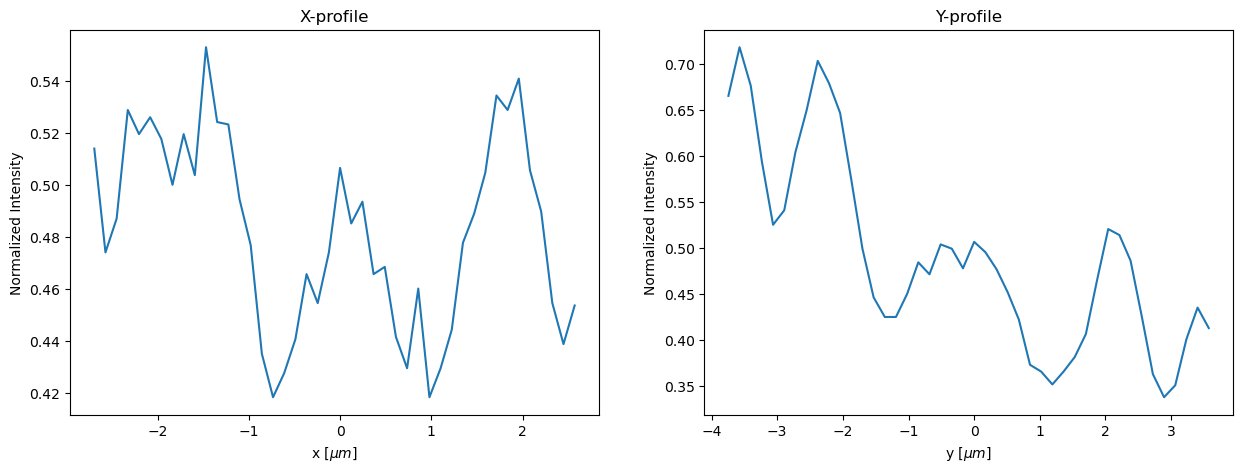

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# X-profile
ax1.plot(x_shift, x_profile, label='x-profile')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('Normalized Intensity')
ax1.set_title('X-profile')

# Y-profile
ax2.plot(y_shift, y_profile, label='y-profile')
ax2.set_xlabel('y [$\mu m$]')
ax2.set_ylabel('Normalized Intensity')
ax2.set_title('Y-profile')

plt.show()


We can see that the profiles are slightly tilted (more prominently in the y-profile). This is due to the varying intensity along the axis. This intensity variation can be quantified by using the profile of the complete filtered beam. Because the beam is elliptical, we can't use the overall profile. A new profile will have to be made on the axis in question.

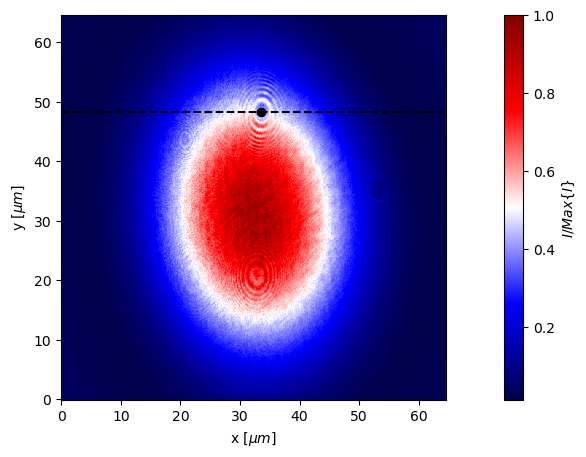

In [21]:
# Gets the beam profile along the axis of the dust
fig,ax1 = plt.subplots(figsize=(15,5))

## PLot 1: Total Picture
ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), label='cleaned beam', cmap = 'hot')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('y [$\mu m$]')

# Sets a colourbar
cbar = plt.colorbar(ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), cmap = 'seismic'))
# cbar = plt.colorbar(ax.pcolormesh(master_dark, cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')
ax1.set_aspect('equal')

# Plots a box around the point of interest
i1x = 274
i1y = 283
ax1.plot(x_coords[i1x], y_coords[i1y], 'ko')
d = 22
x_start = i1x - d; x_end = i1x + d
y_start = i1y - d ; y_end   = i1y + d
# ax1.axvline(x_coords[x_start], color='k', linestyle='--')
# ax1.axvline(x_coords[x_end], color='k', linestyle='--')
# ax1.axhline(y_coords[y_start], color='k', linestyle='--')
# ax1.axhline(y_coords[y_end], color='k', linestyle='--')
ax1.axhline(y_coords[i1y], color='k', linestyle='--')


# # Plot 2: Zoomed in picture
# # Shifts the coordinates to be centered around the middle of the airy disk
# x_shift = x_coords[x_start:x_end] - x_coords[i1x]
# y_shift = y_coords[y_start:y_end] - y_coords[i1y]

# ax2.pcolormesh(x_shift, y_shift, cleaned_beam[y_start:y_end, x_start:x_end] / np.max(cleaned_beam), label='cleaned beam', cmap = 'hot')
# ax2.set_xlabel('x [$\mu m$]')
# ax2.set_ylabel('y [$\mu m$]')
# cbar = plt.colorbar(ax2.pcolormesh(x_shift, y_shift, cleaned_beam[y_start:y_end, x_start:x_end] / np.max(cleaned_beam), cmap = 'hot'))
# cbar.set_label('$I/Max\{I\}$')

# # Plots lines on the 2nd plot to show plot belows region
# ax2.vlines(0, np.min(y_shift), np.max(y_shift), color = 'k', linestyle='--')
# ax2.hlines(0, np.min(x_shift), np.max(x_shift), color = 'k', linestyle='--')

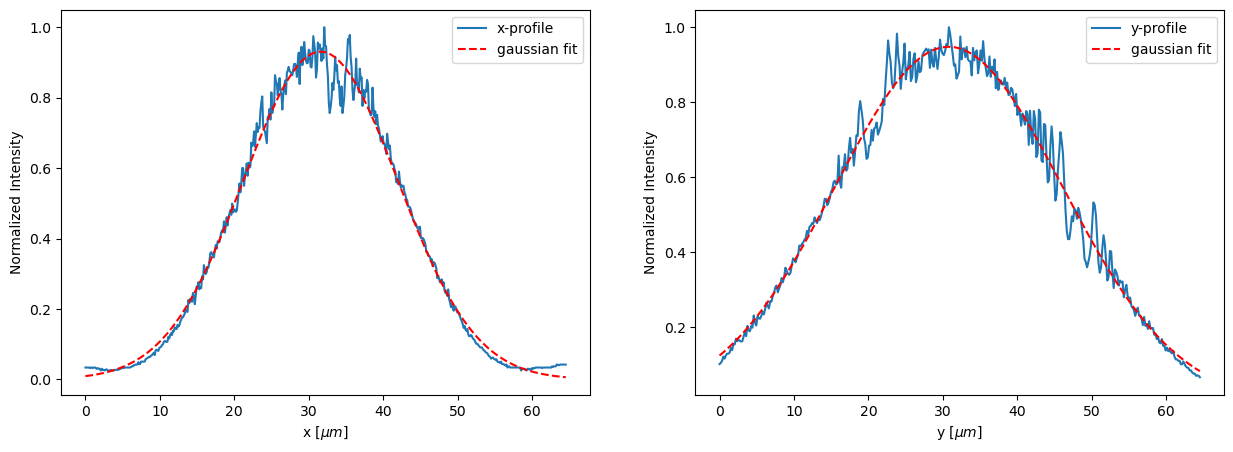

In [40]:
# Gets the x and y profiles of the beam
x_prof_1 = cleaned_beam[i1y, :]
y_prof_1 = cleaned_beam[:, i1x]

# Fits a gaussian to the x and y profiles
x_prof_model = curve_fit(gaussian, x_coords, x_prof_1)
y_prof_model = curve_fit(gaussian, y_coords, y_prof_1)

# gets the errors on the models
x_prof1_err = np.sqrt(np.diag(x_model[1]))
y_prof1_err = np.sqrt(np.diag(y_model[1]))

# Calculates the fits
x_prof1_fit = gaussian(x_coords, *x_prof_model[0])
y_prof1_fit = gaussian(y_coords, *y_prof_model[0])

# Plots the profiles
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# X-profile
ax1.plot(x_coords, x_prof_1 / np.max(x_prof_1), label='x-profile')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('Normalized Intensity')
ax1.plot(x_coords, x_prof1_fit / np.max(x_prof_1), 'r--', label='gaussian fit')
ax1.legend()
# ax1.set_aspect('equal')

# Y-profile
ax2.plot(y_coords, y_prof_1 / np.max(y_prof_1), label='y-profile')
ax2.set_xlabel('y [$\mu m$]')
ax2.set_ylabel('Normalized Intensity')
ax2.plot(y_coords, y_prof1_fit / np.max(y_prof_1), 'r--', label='gaussian fit')
ax2.legend()
# ax2.set_aspect('equal')

plt.show()

With these profiles, we can now subtract the fit from our data in the region of interest

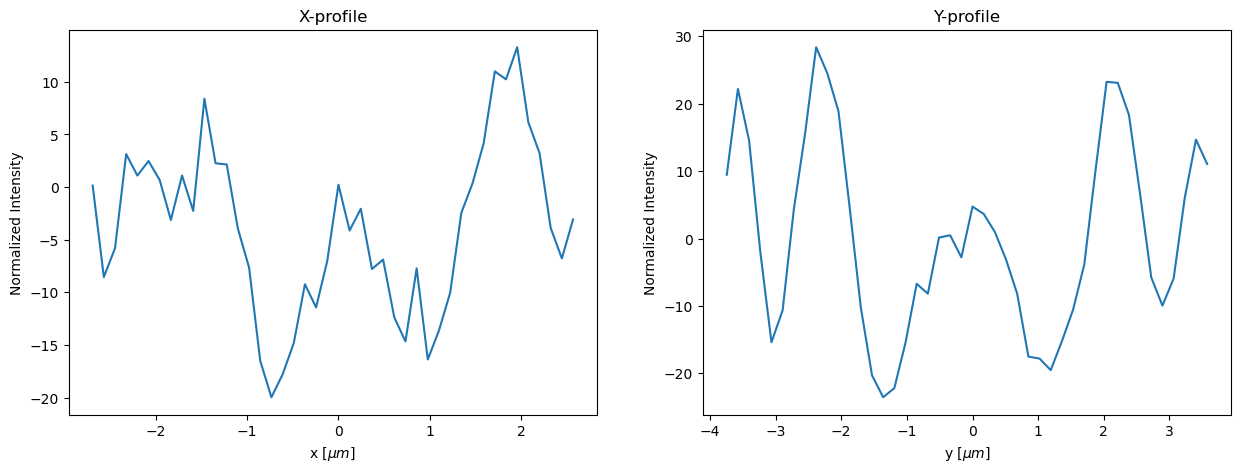

In [42]:
# Gets the zoomed in data normalized to the total max intensity
x_p1_cleaned = cleaned_beam[i1y, x_start:x_end] - x_prof1_fit[x_start:x_end]
y_p1_cleaned = cleaned_beam[y_start:y_end,i1x]  - y_prof1_fit[y_start:y_end]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# X-profile
ax1.plot(x_shift, x_p1_cleaned, label='x-profile')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('Normalized Intensity')
ax1.set_title('X-profile')

# Y-profile
ax2.plot(y_shift, y_p1_cleaned, label='y-profile')
ax2.set_xlabel('y [$\mu m$]')
ax2.set_ylabel('Normalized Intensity')
ax2.set_title('Y-profile')
plt.show()

Now that we have our data isolated, we can begin to fit our functions to this. We use the fresnel integrals,
$$
    C(w) = \int_0^wdw' \cos\left(\frac{\pi w'^2}{2}\right) \quad\quad\quad
    S(w) = \int_0^wdw' \sin\left(\frac{\pi w'^2}{2}\right)
$$
Using these, the intensity is given by,
$$
    I^x\sim [C(\gamma x_2)-C(\gamma x_1)]^2 + [S(\gamma x_2)-S(\gamma x_1)]^2 \quad\quad\quad
    I^y\sim [C(\gamma y_2)-C(\gamma y_1)]^2 + [S(\gamma y_2)-S(\gamma y_1)]^2
$$
where $\gamma$ is our fitting parameter representing
$$
    \gamma = \left(\frac{2\rho_0 r_0}{\lambda\rho_0 r_0}\right)^{1/2}
$$

In [ ]:
import scipy.special as sc

# Defines the functions to be fitted
def intensity_model(x, a):
    cos_term = sp.fresnel(a*x)[0]
    sin_term = sp.fresnel(a*x)[1]
    